# Pipeline for the anomaly detection on the SKAB using MSCRED

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../algorithms')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data

Put the `data` folder from the SKAB repository in the root of this repository. So the path will be following: `../data/`. Or select your own path.

In [2]:
path_to_data = '../data/'

## Data loading

In [3]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [4]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

### Data description

In [5]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


Accelerometer1RMS  Accelerometer2RMS  Current  Pressure  \
datetime                                                                       
2020-03-01 15:44:06           0.082065           0.133521  1.27794  0.054711   

                     Temperature  Thermocouple  Voltage  Volume Flow RateRMS  \
datetime                                                                       
2020-03-01 15:44:06      92.2562       22.2577  209.639              76.0197   

                     anomaly  changepoint  
datetime                                   
2020-03-01 15:44:06      0.0          0.0

### Data visualization

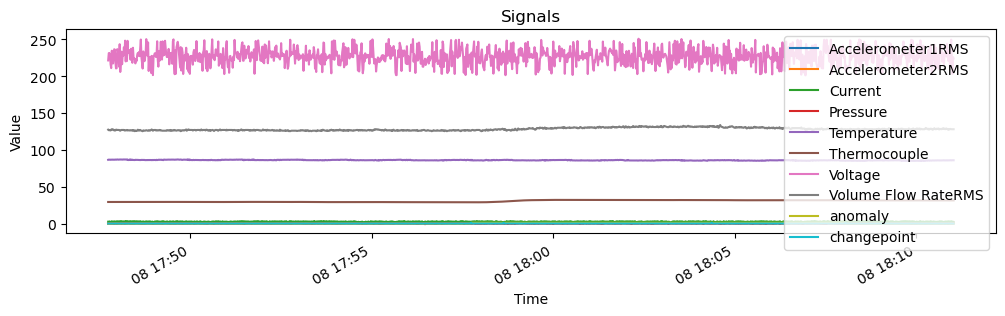

In [6]:
# random dataset visualizing
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

### Labels visualization

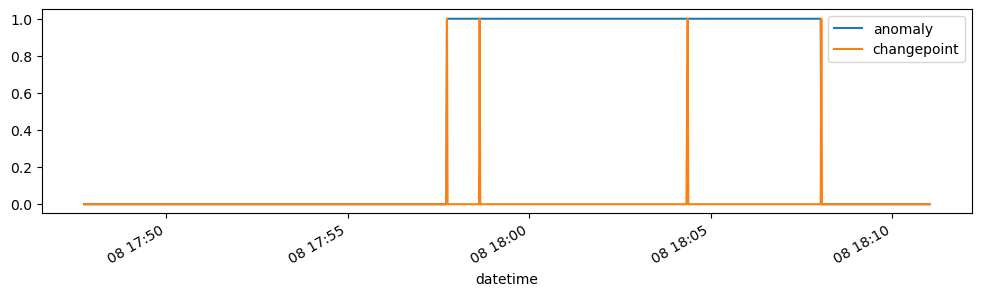

In [7]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method

### Method initialization

In [8]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [9]:
from MSCRED import MSCRED
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [10]:
# hyperparameters selection
step_max = 5              # maximum step in ConvLSTM
gap_time = 1               # gap time between each segment
win_size = [5, 10, 30]            # window size of each segment
scale_n = len(win_size)
Q = 0.99 # quantile for upper control limit (UCL) selection

In [11]:
def create_dataset(df, win_size, gap_time, step_max):

    data = np.array(df, dtype=np.float64)
    sensor_n = data.shape[1]
    data_all = []
    scale_n = len(win_size)
    # min-max normalization
    data = MinMaxScaler().fit_transform(data).T

    for win in win_size:
        matrix_all = []
        print(f"generating signature with window {win} ...")
        for t in range(win_size[-1], len(df), gap_time):
            matrix_t = np.zeros((sensor_n, sensor_n))
            for i in range(sensor_n):
                for j in range(i, sensor_n):
                    matrix_t[i][j] = np.inner(data[i, t - win:t], data[j, t - win:t])/(win) # rescale by win
                    matrix_t[j][i] = matrix_t[i][j]
            matrix_all.append(matrix_t)
        data_all.append(matrix_all)

    data_all = np.transpose(data_all, (1,2,3,0))

    print (f"create dataset ...")

    dataset = data_all[:step_max]
    for i in range(step_max+1, len(data_all)+1):
        dataset = np.append(dataset, data_all[i-step_max:i], axis=0)

    return dataset.reshape([-1, step_max, sensor_n, sensor_n, scale_n])

### Method fitting and applying

----------------------dataset №1--------------------------------
generating signature with window 5 ...
generating signature with window 10 ...
generating signature with window 30 ...
create dataset ...
Epoch 1/25
3/3 [==============================] - 16s 1s/step - loss: 0.1163 - val_loss: 0.0306 - lr: 0.0010
Epoch 2/25
3/3 [==============================] - 2s 750ms/step - loss: 0.0287 - val_loss: 0.0125 - lr: 0.0010
Epoch 3/25
3/3 [==============================] - 2s 748ms/step - loss: 0.0149 - val_loss: 0.0124 - lr: 0.0010
Epoch 4/25
3/3 [==============================] - 2s 719ms/step - loss: 0.0104 - val_loss: 0.0096 - lr: 0.0010
Epoch 5/25
3/3 [==============================] - 2s 737ms/step - loss: 0.0072 - val_loss: 0.0086 - lr: 0.0010
Epoch 6/25
3/3 [==============================] - 2s 716ms/step - loss: 0.0065 - val_loss: 0.0072 - lr: 0.0010
Epoch 7/25
3/3 [==============================] - 2s 677ms/step - loss: 0.0045 - val_loss: 0.0068 - lr: 0.0010
Epoch 8/25
3/3 [======

<timed exec>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


generating signature with window 10 ...
generating signature with window 30 ...
create dataset ...
Epoch 1/25
3/3 [==============================] - 19s 2s/step - loss: 0.1205 - val_loss: 0.0353 - lr: 0.0010
Epoch 2/25
3/3 [==============================] - 5s 2s/step - loss: 0.0278 - val_loss: 0.0211 - lr: 0.0010
Epoch 3/25
3/3 [==============================] - 5s 2s/step - loss: 0.0122 - val_loss: 0.0154 - lr: 0.0010
Epoch 4/25
3/3 [==============================] - 5s 2s/step - loss: 0.0069 - val_loss: 0.0121 - lr: 0.0010
Epoch 5/25
3/3 [==============================] - 5s 2s/step - loss: 0.0051 - val_loss: 0.0113 - lr: 0.0010
Epoch 6/25
3/3 [==============================] - 5s 2s/step - loss: 0.0044 - val_loss: 0.0101 - lr: 0.0010
Epoch 7/25
3/3 [==============================] - 5s 2s/step - loss: 0.0034 - val_loss: 0.0091 - lr: 0.0010
Epoch 8/25
3/3 [==============================] - 5s 2s/step - loss: 0.0033 - val_loss: 0.0085 - lr: 0.0010
Epoch 9/25
3/3 [====================

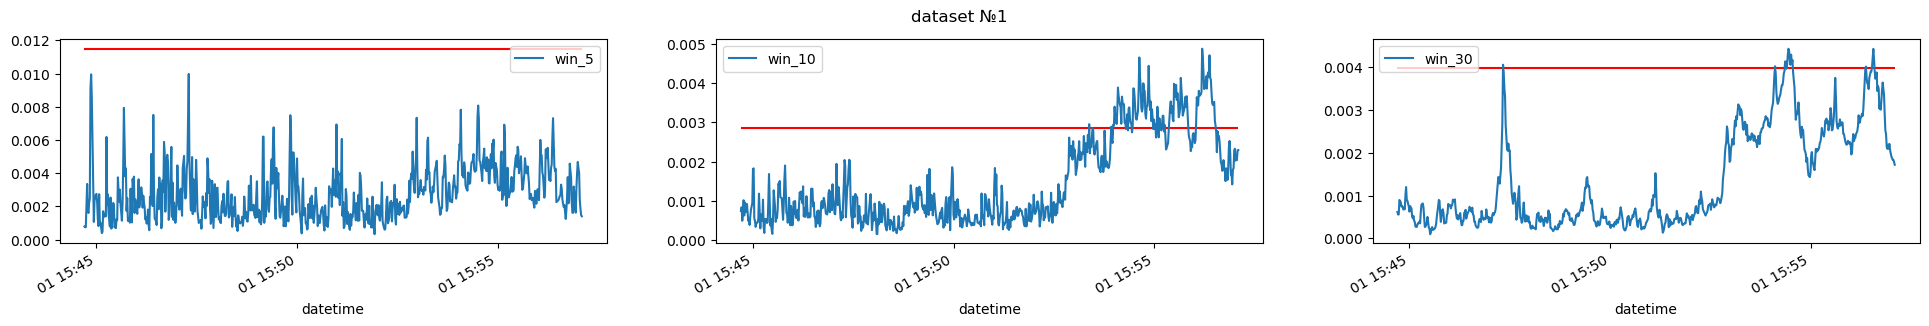

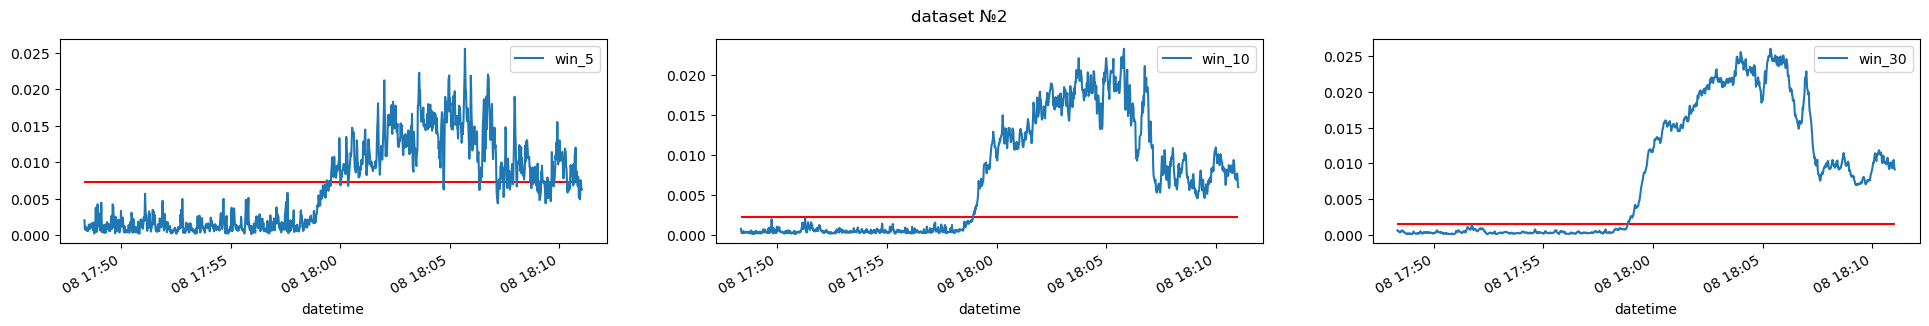

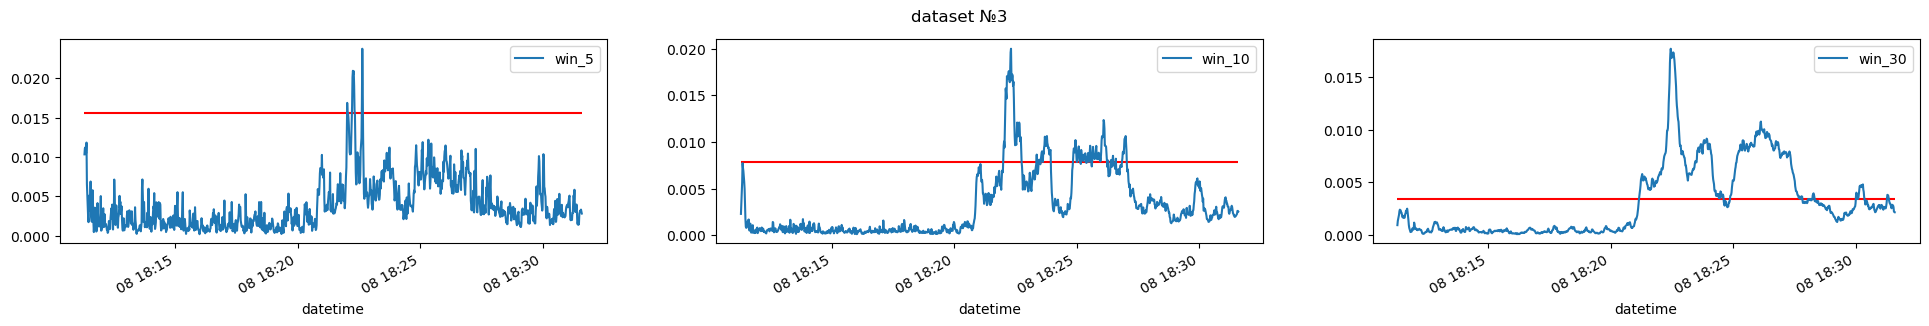

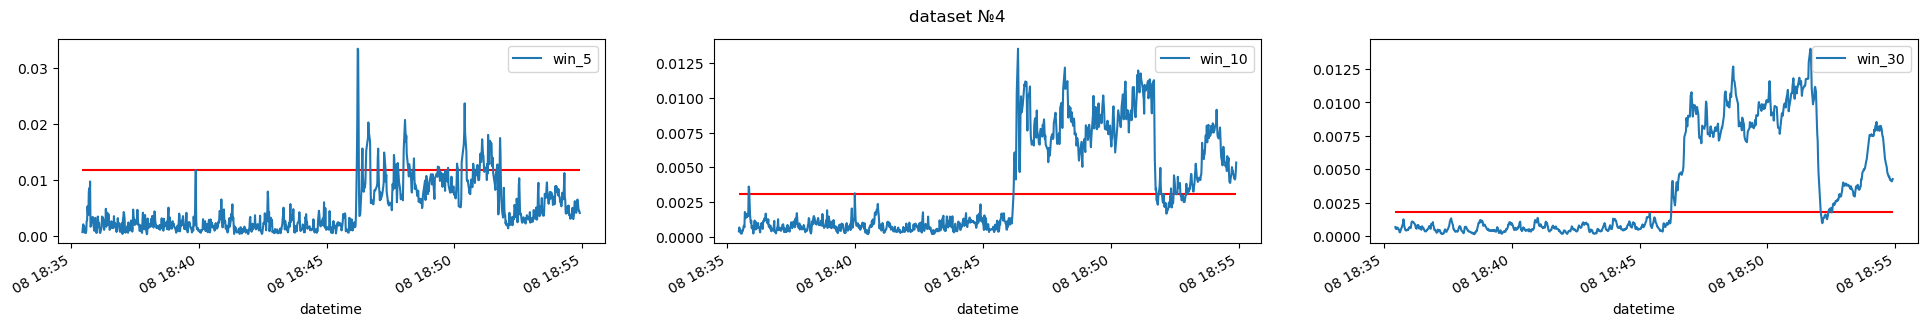

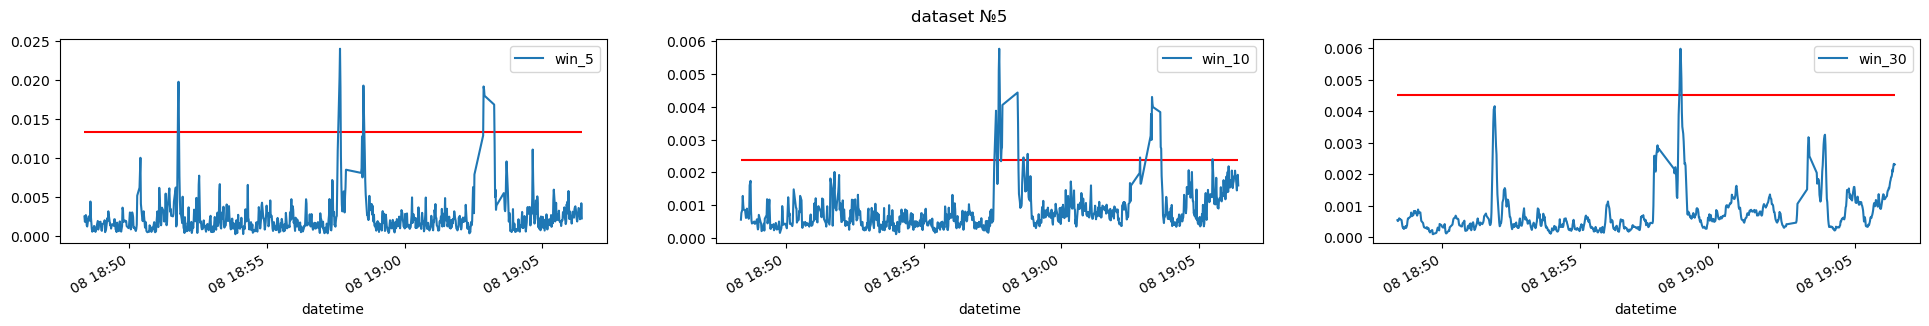

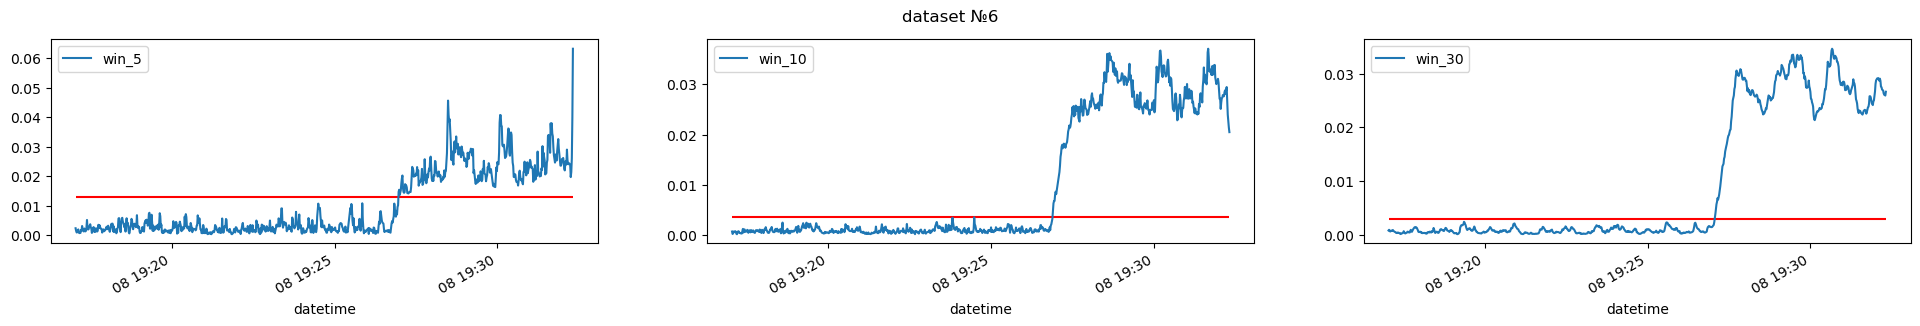

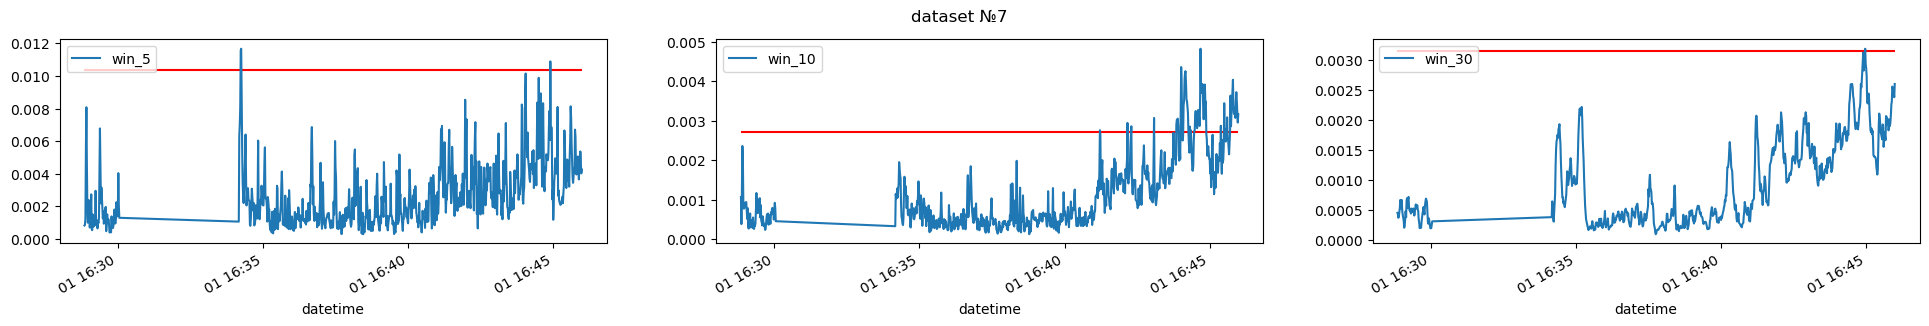

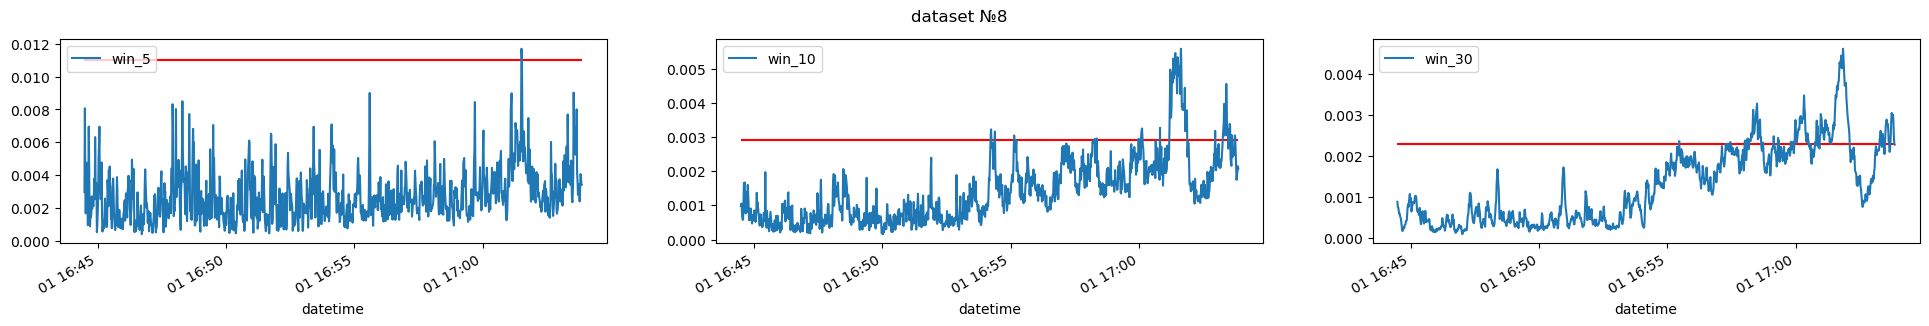

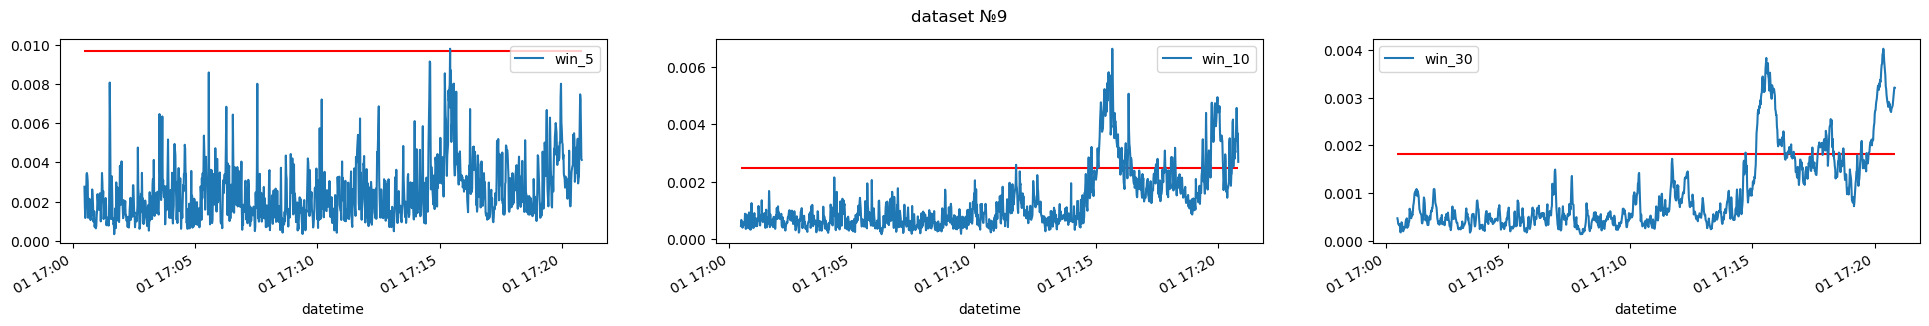

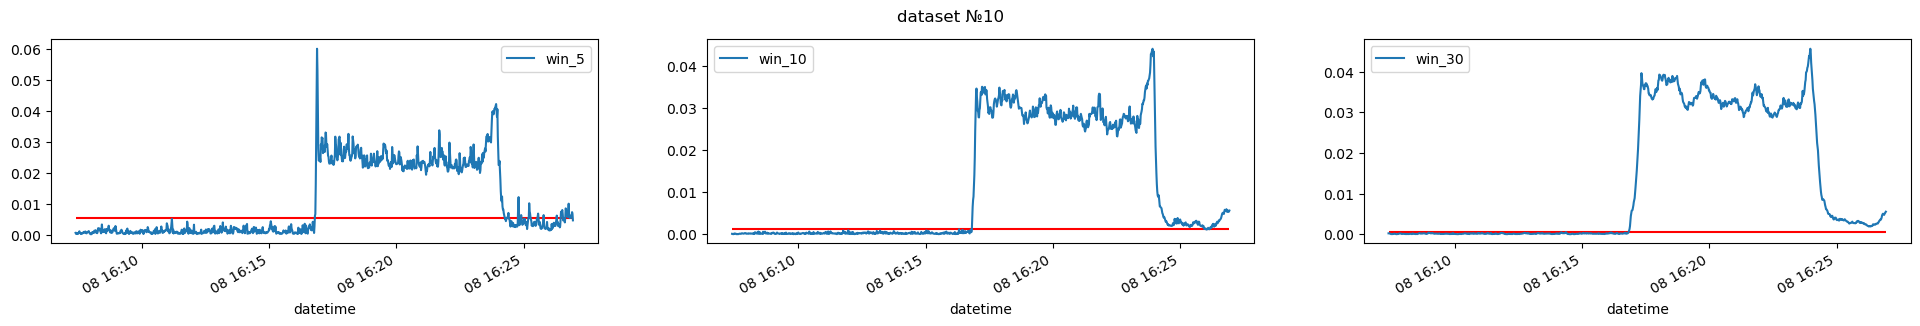

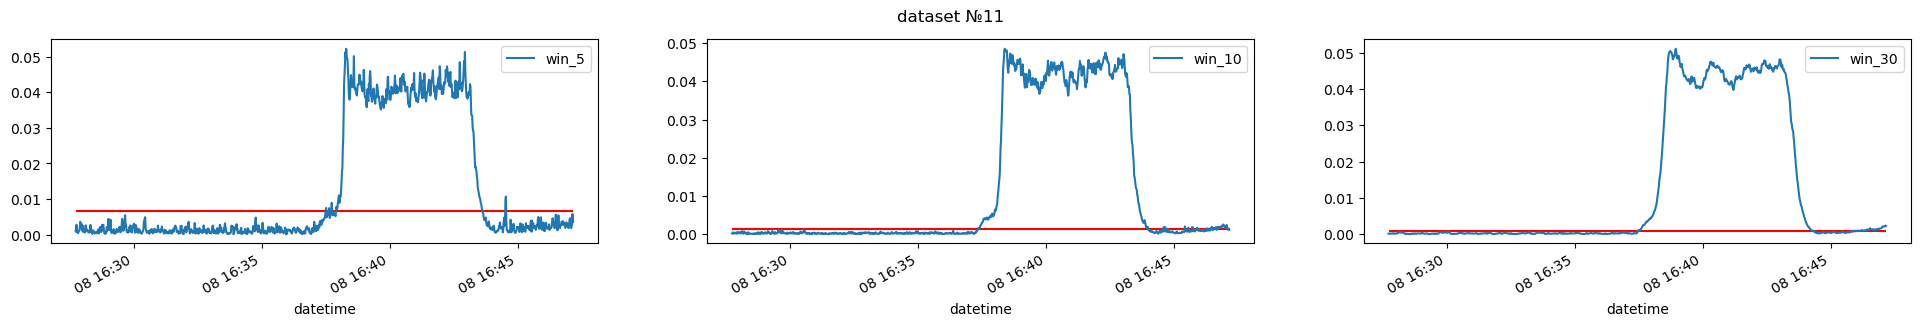

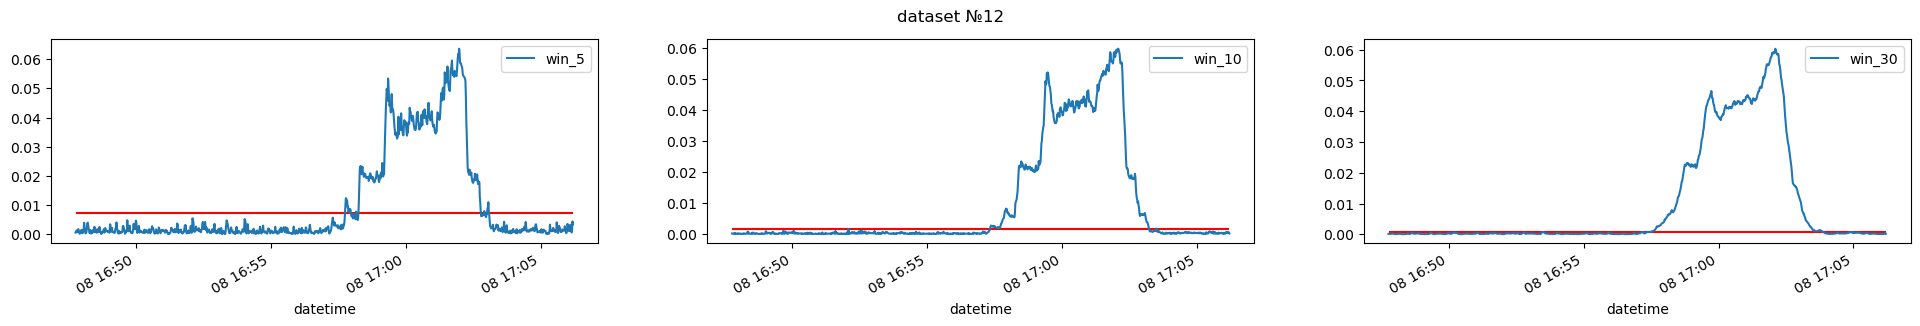

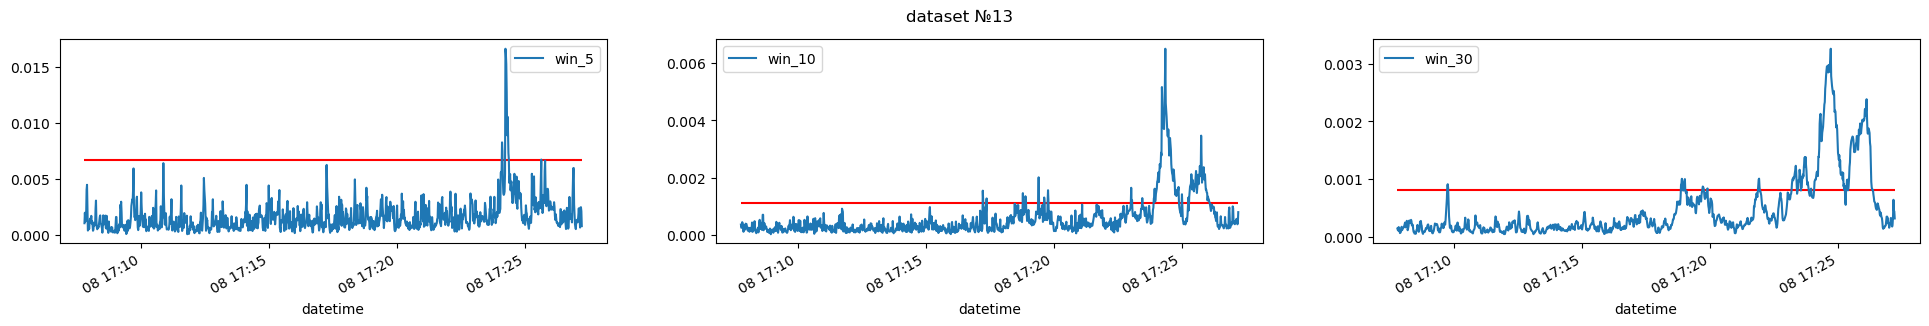

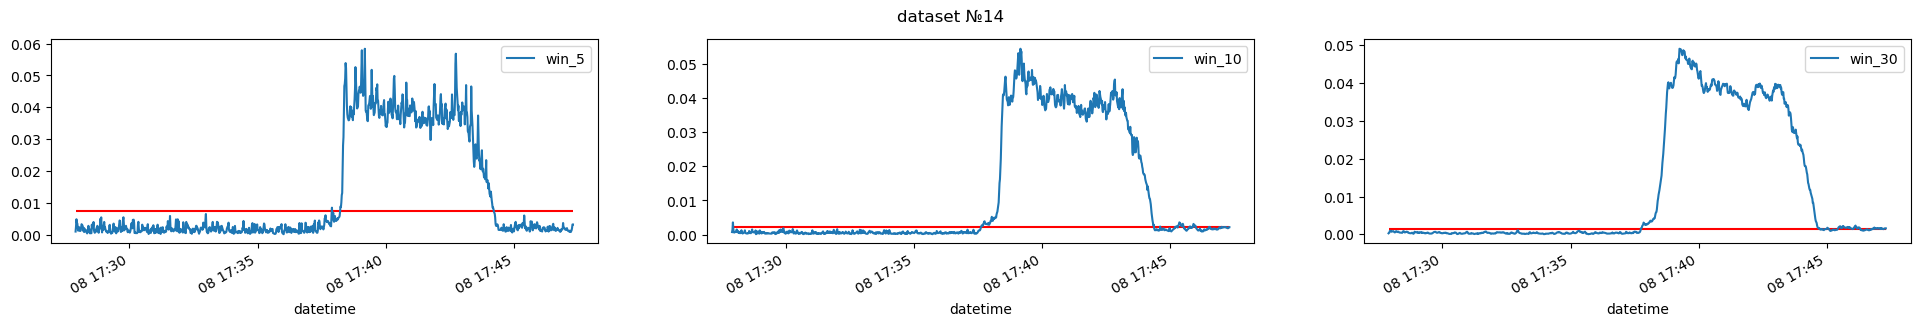

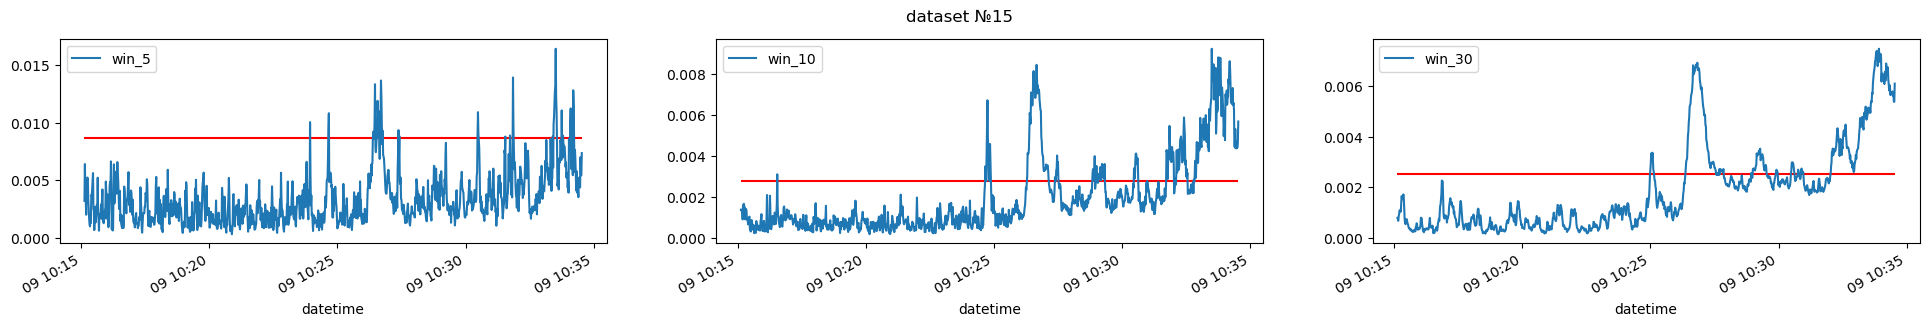

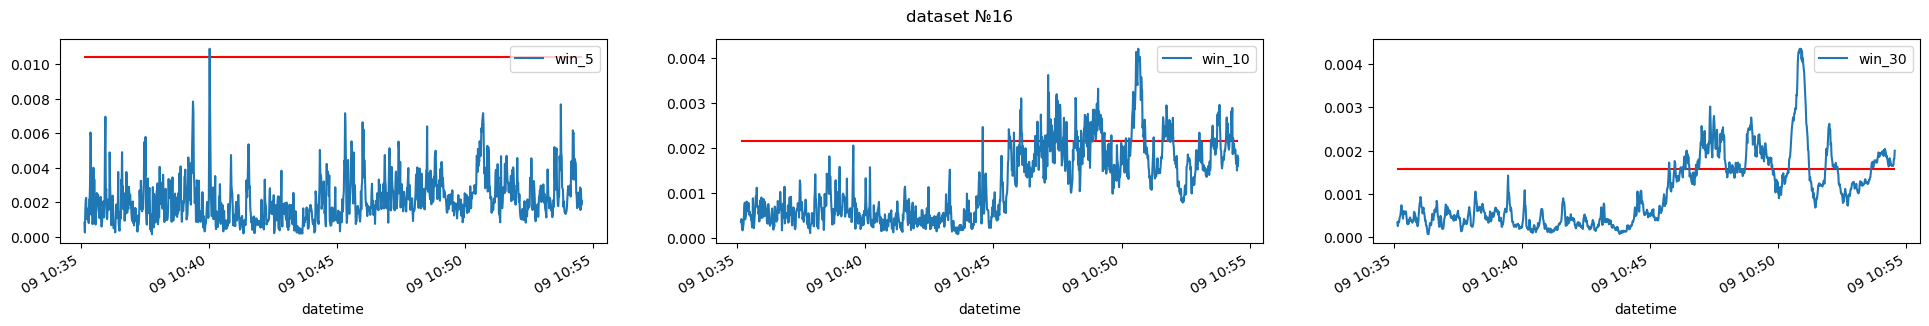

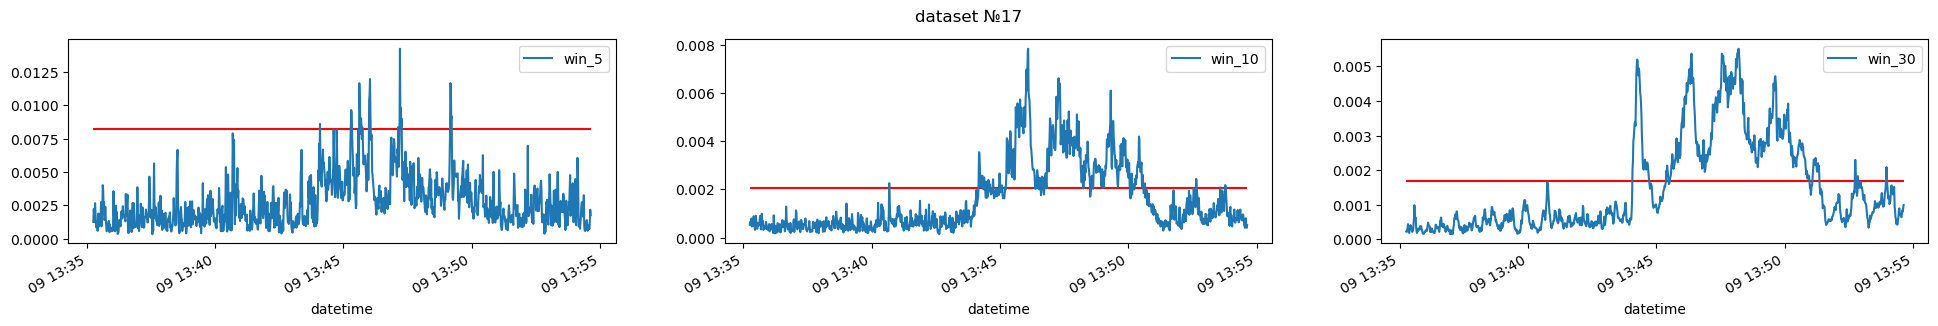

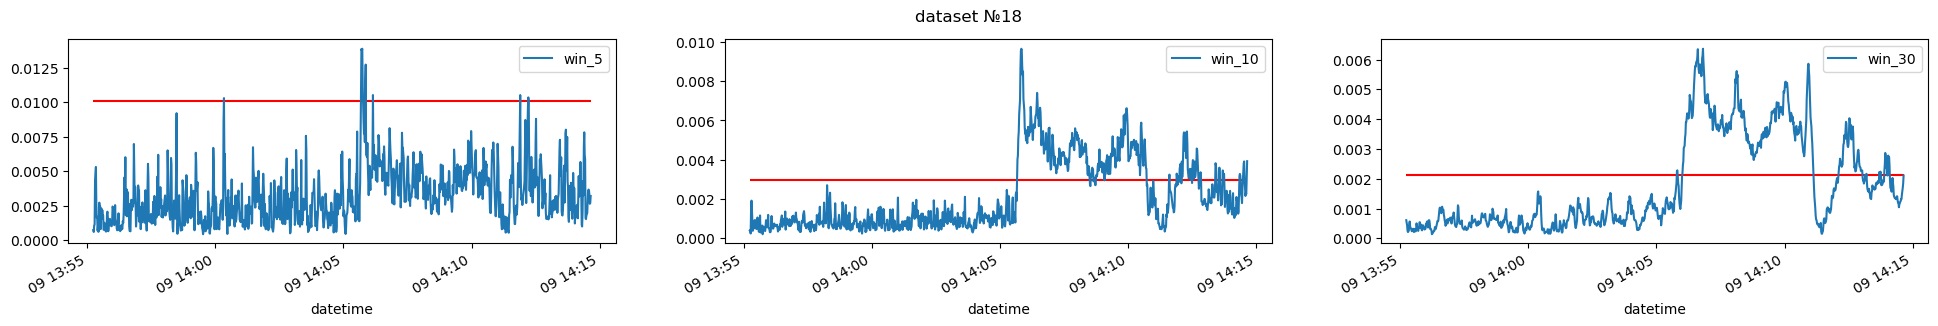

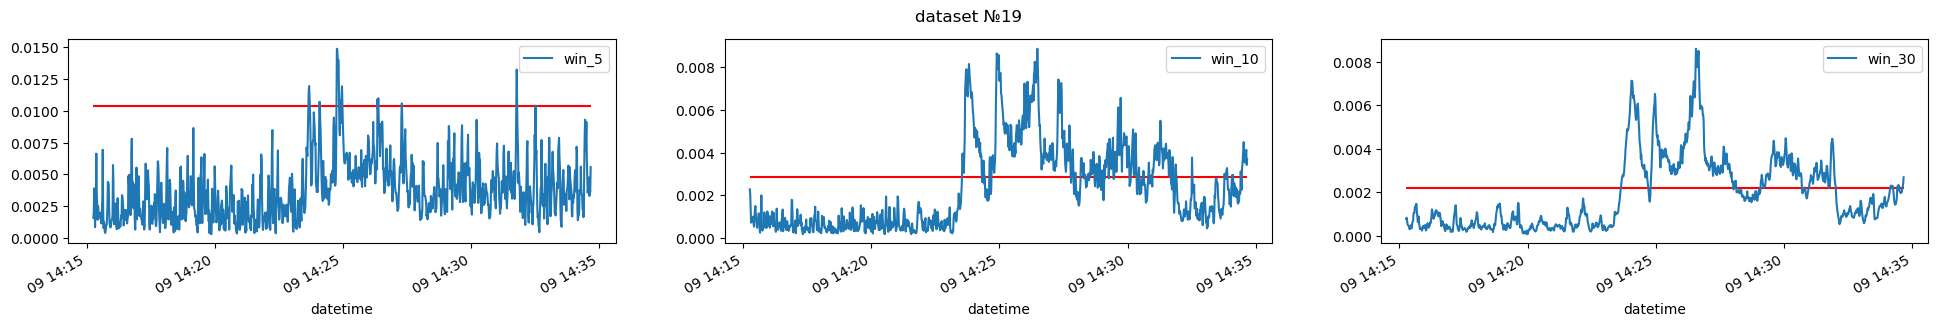

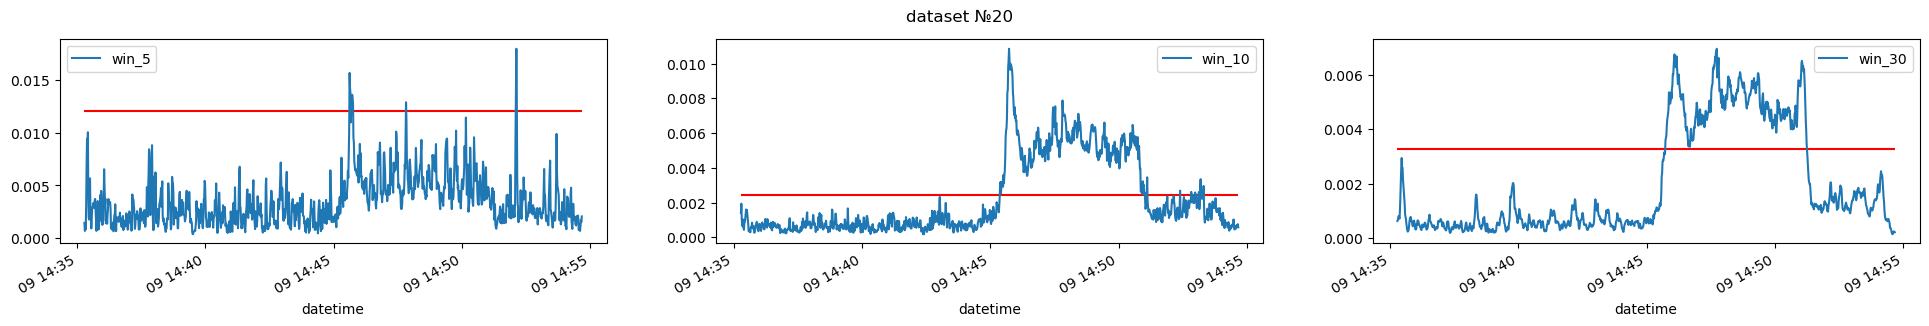

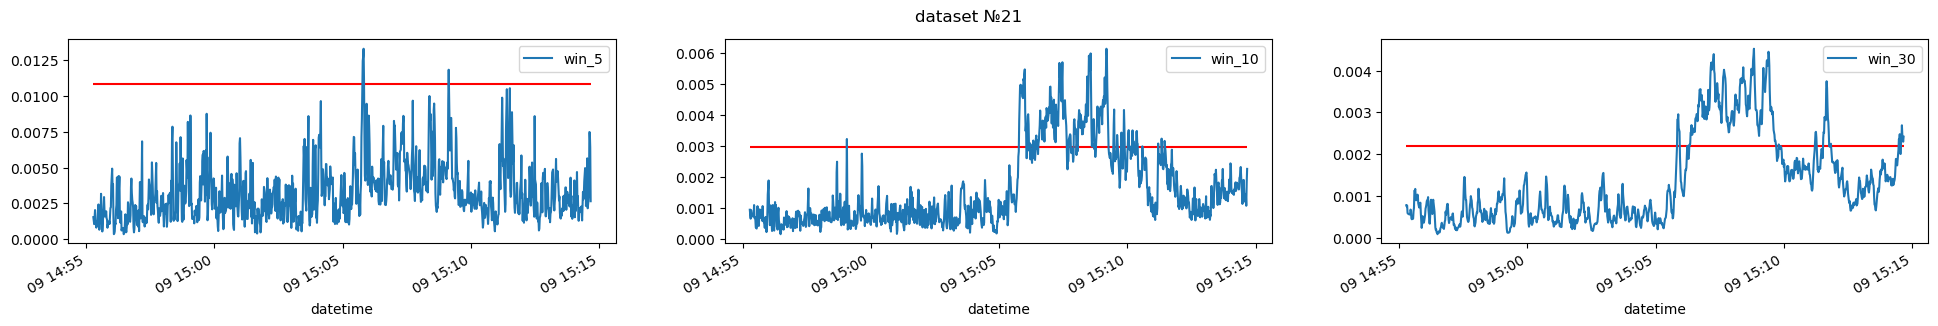

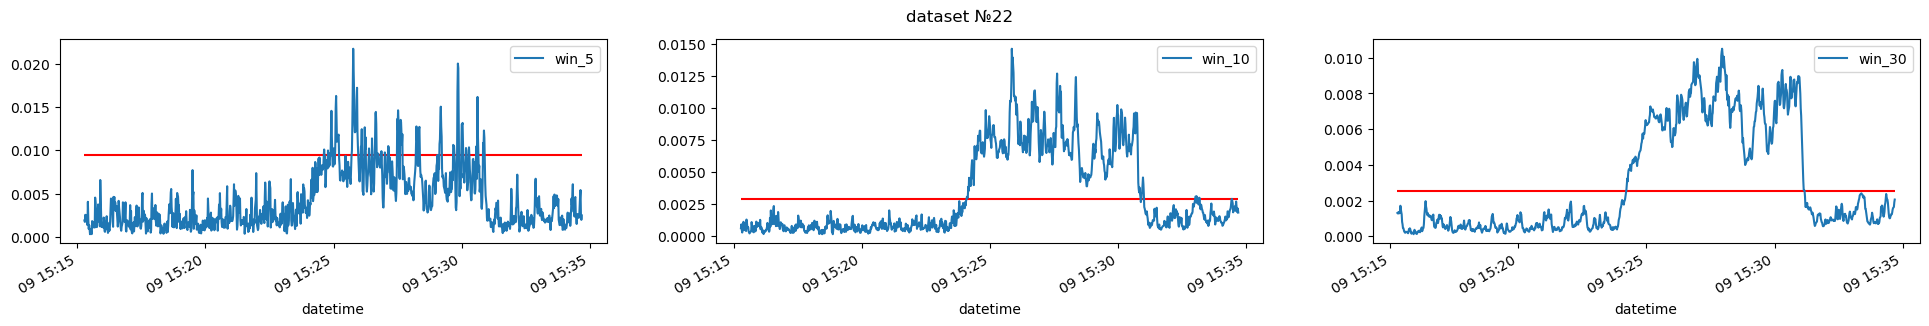

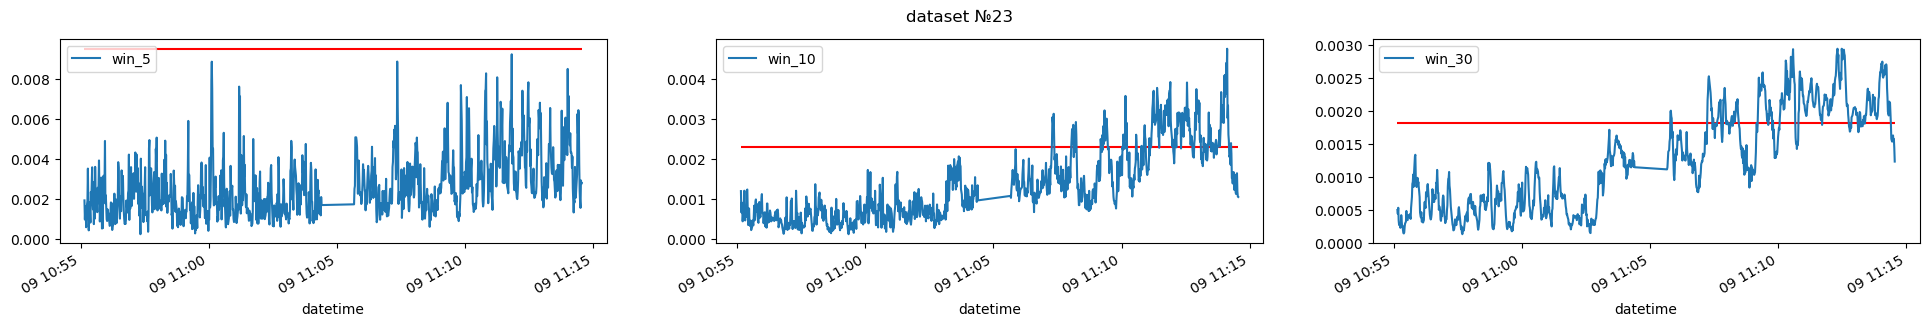

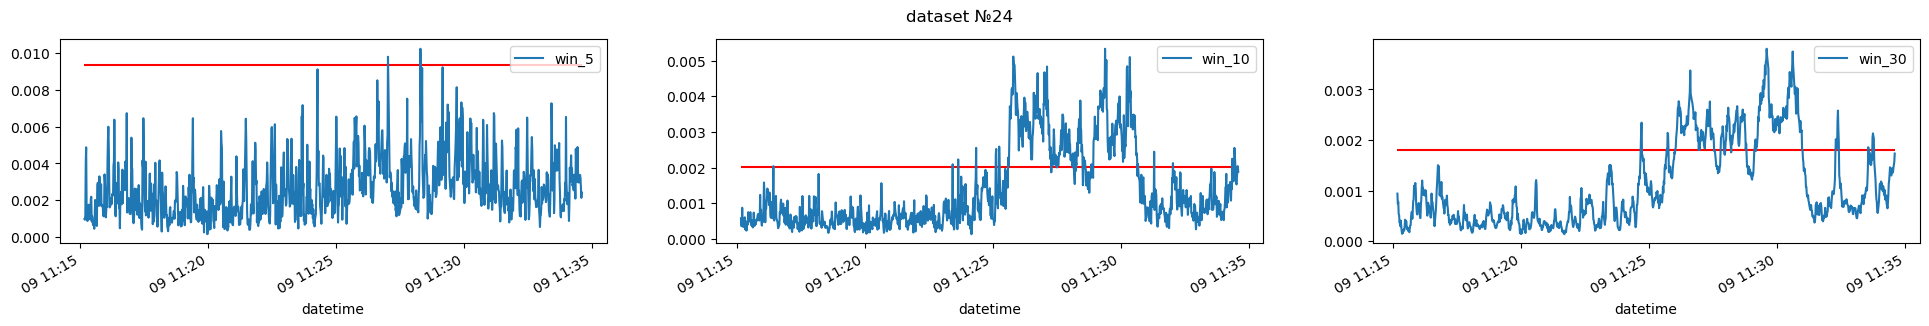

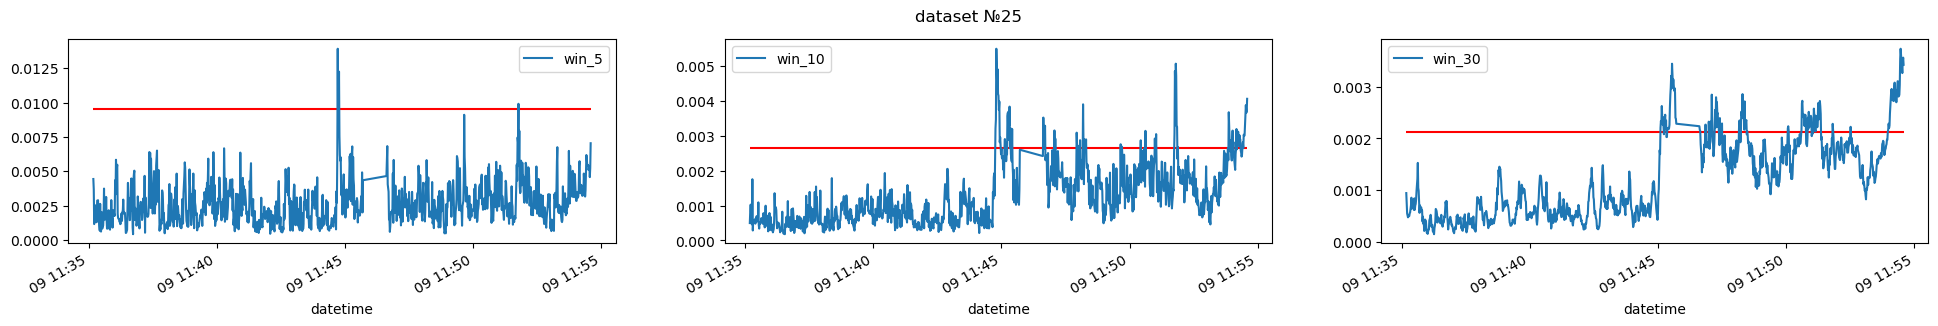

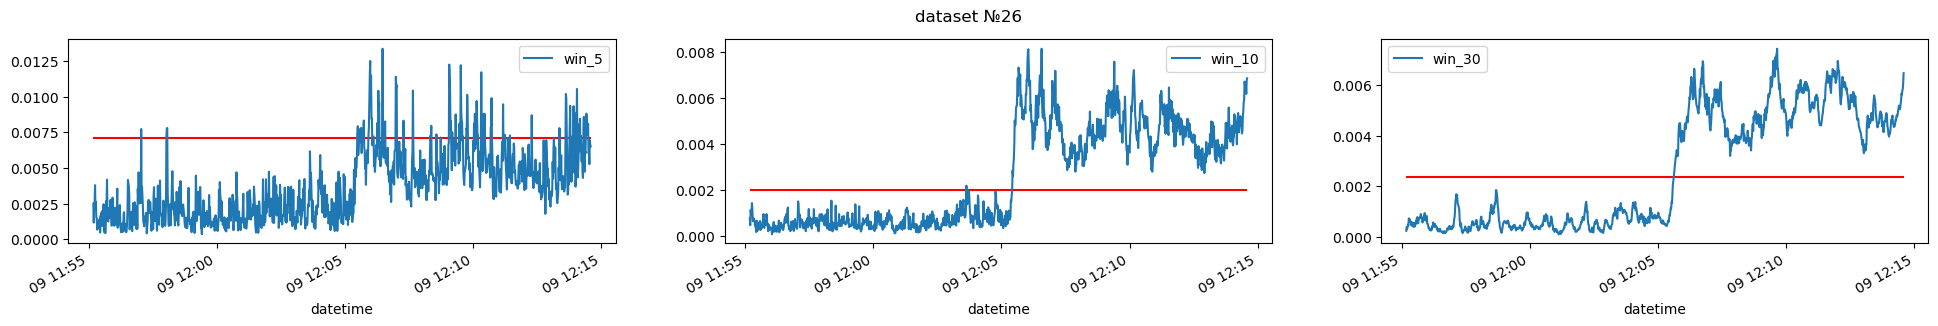

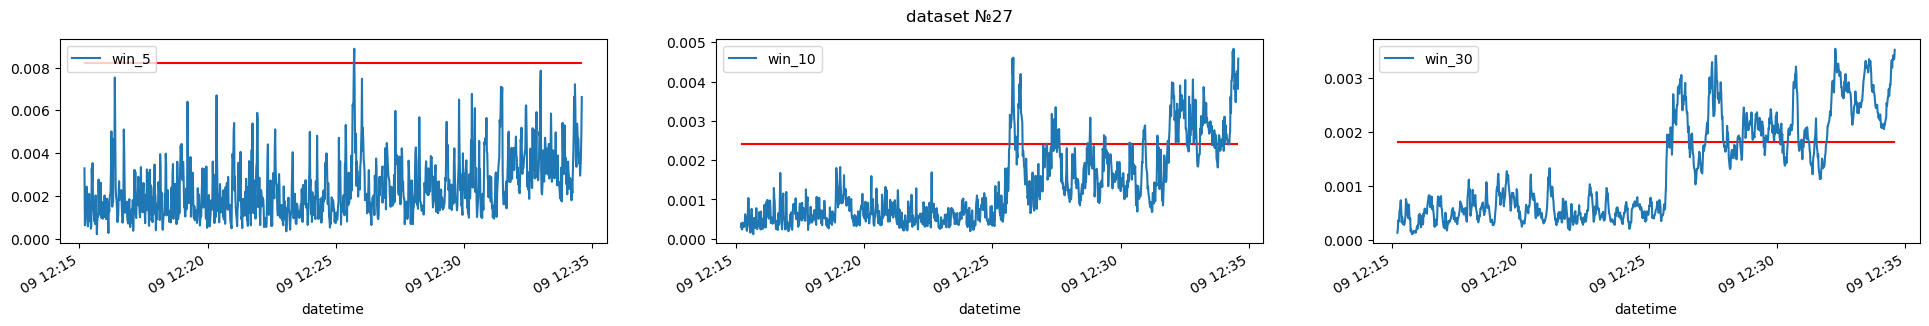

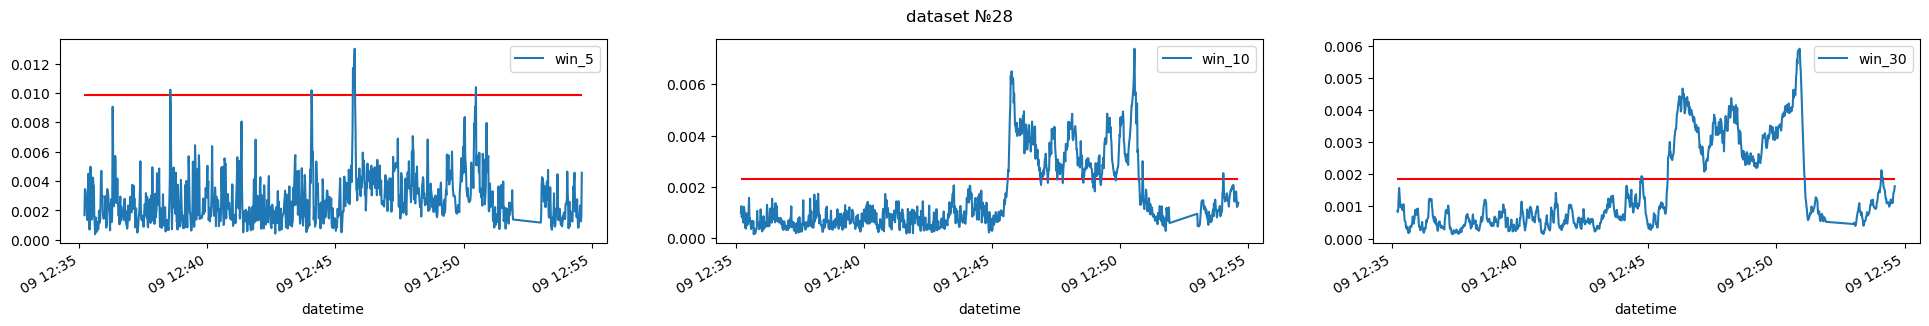

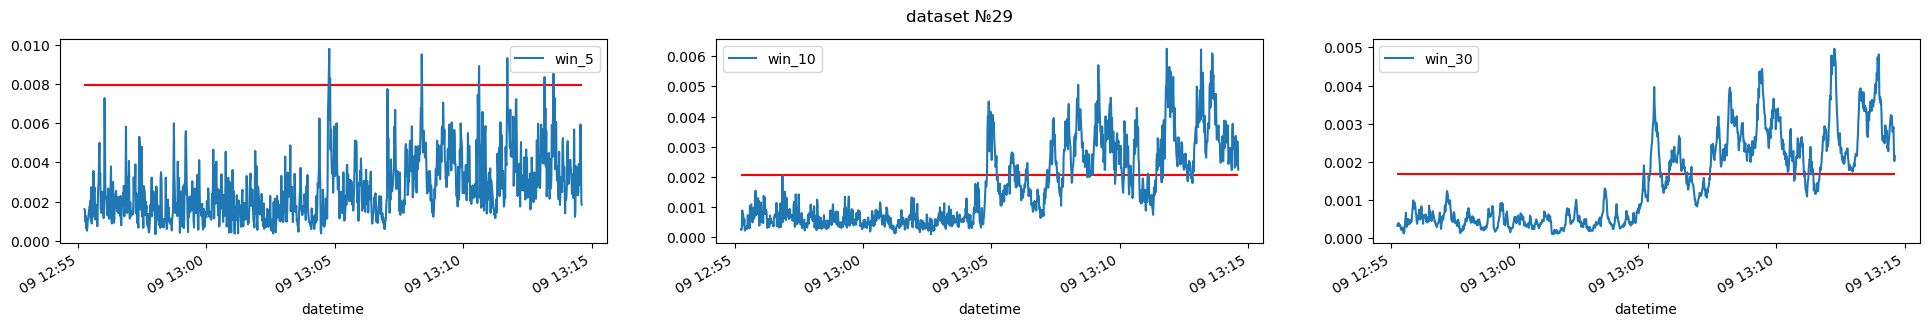

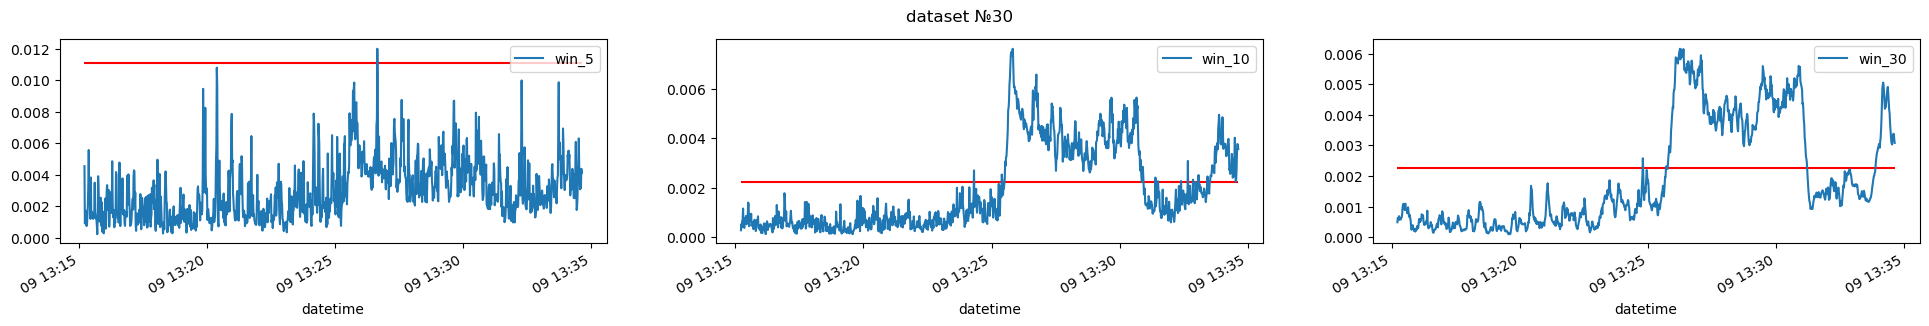

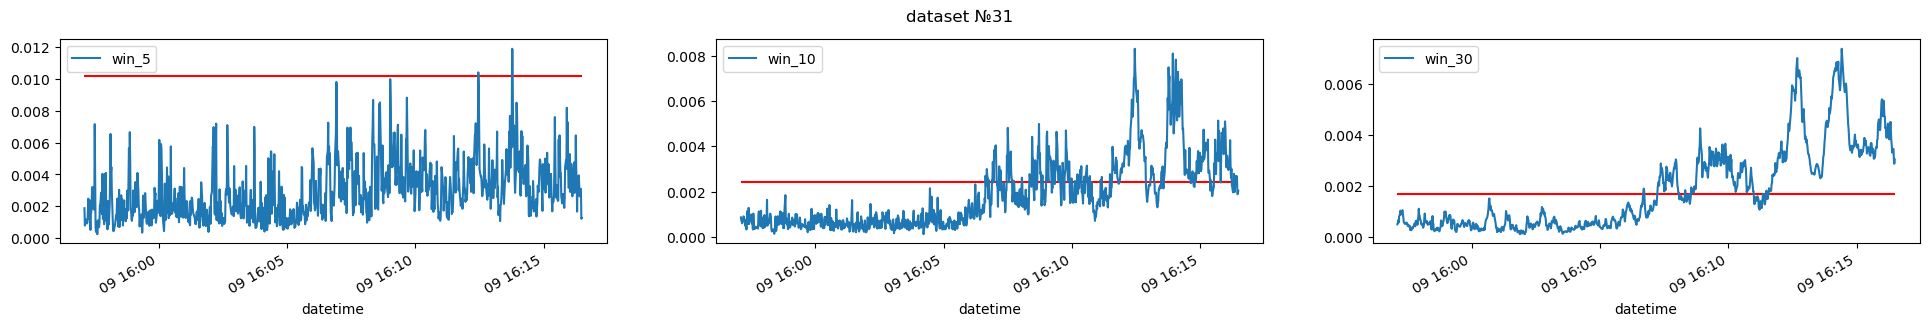

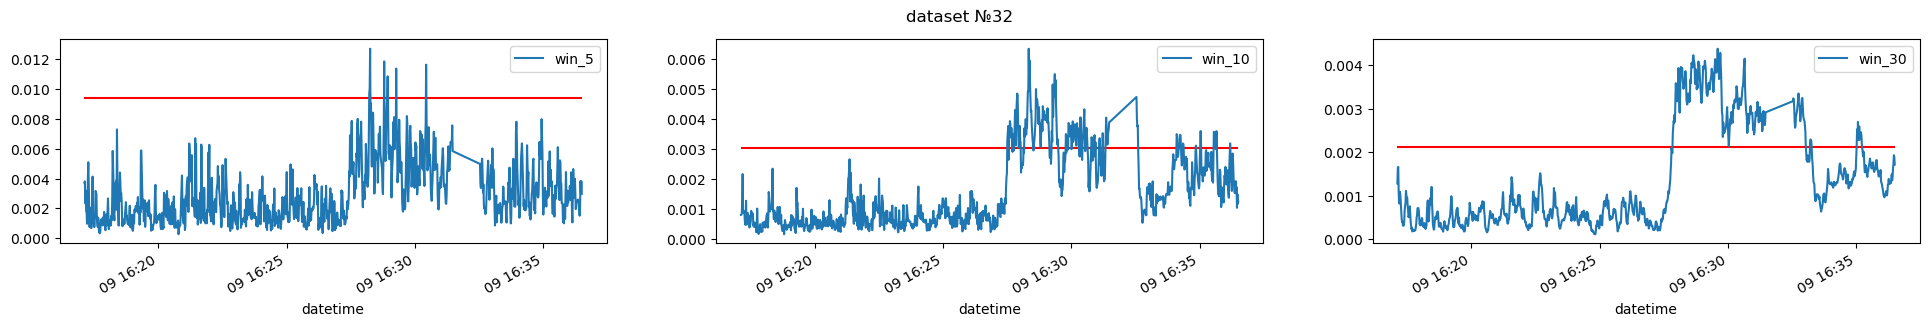

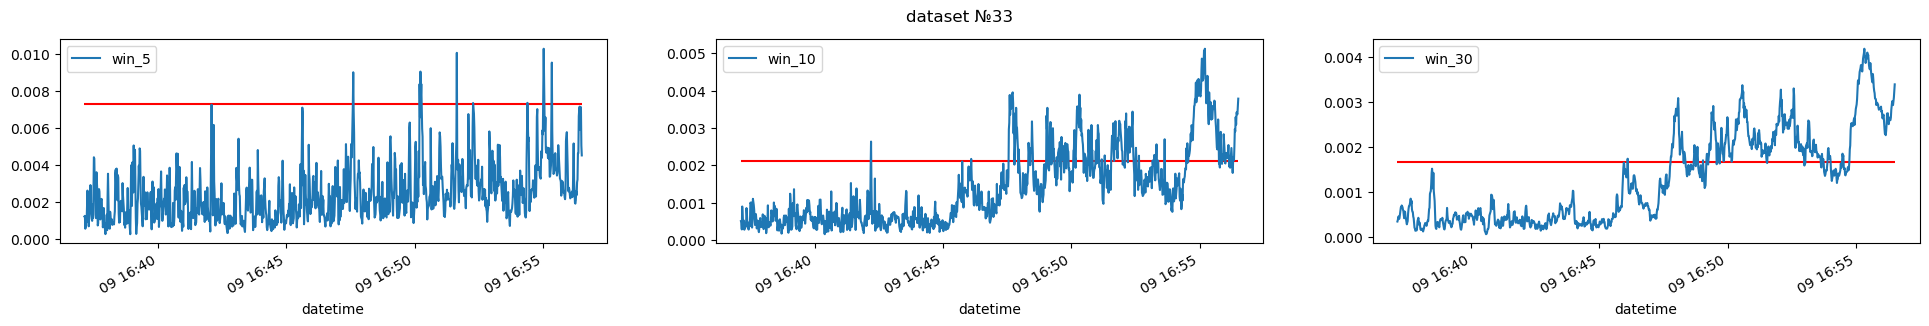

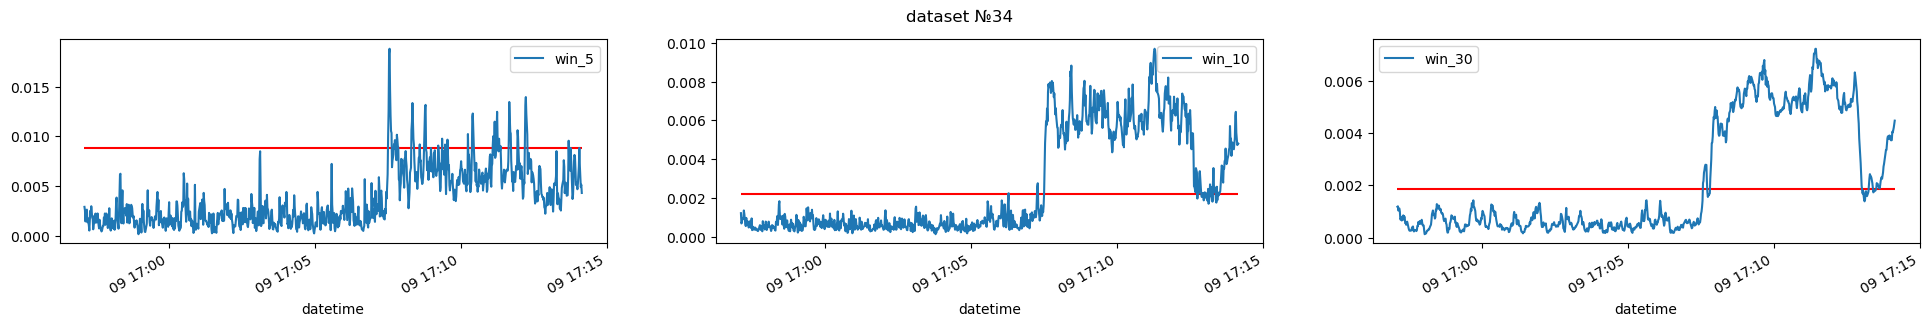

In [12]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
mses = []
x = 0 
for df in list_of_df:
    
    x += 1
    print(f'----------------------dataset №{x}--------------------------------')
    df = df.drop(['anomaly','changepoint'], axis=1)
    sensor_n = df.shape[1]
    dataset = create_dataset(df, win_size, gap_time, step_max)
    train_stop = (500 - win_size[-1])//gap_time - step_max
    
    X_train = dataset[:train_stop]
    Y_train = dataset[:train_stop, -1]
    X_test = dataset[train_stop:]
    Y_test = dataset[train_stop:, -1]
    
    PARAMS = [sensor_n, scale_n, step_max]
    
    # model defining and fitting
    model=MSCRED(PARAMS)
    model.fit(X_train, Y_train, X_test, Y_test)
    
    # results predicting
    Y_pred = model.predict(dataset)
    resid_mat = dataset[:, -1] - Y_pred
    mse = np.mean(np.square(resid_mat), axis=(1,2))
    t = df.index[win_size[-1]::gap_time][step_max-1:]
    mse_df = pd.DataFrame(mse, 
                          index=t,
                          columns=[f'win_{i}' for i in win_size])
    mses.append(mse_df)
    
    UCL = mse_df[:train_stop].quantile(Q) * 3/2
    prediction = pd.DataFrame((mse_df>UCL),
                              t).fillna(0).any(axis=1).astype(int)
    
    # plot 
    fig, axes = plt.subplots(1, len(win_size), figsize=(24,3))
    fig.suptitle(f'dataset №{x}')
    for i, col in enumerate(mse_df.columns):
        ax = axes.flatten()[int(i)]
        ax.hlines(UCL[col], t[0], t[-1], 'r')
        mse_df[col].plot(ax=ax)
        ax.legend()
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

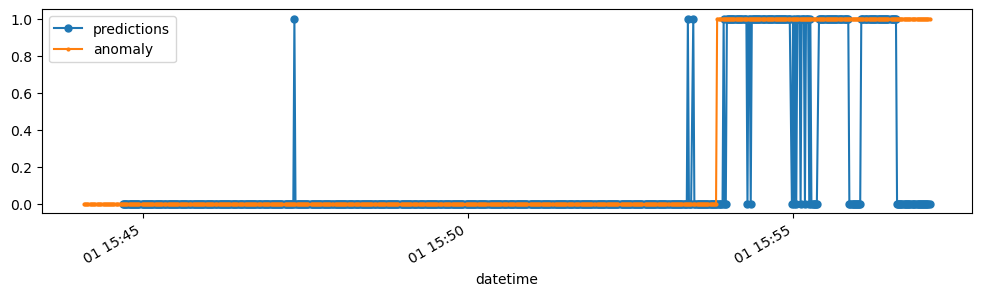

In [19]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

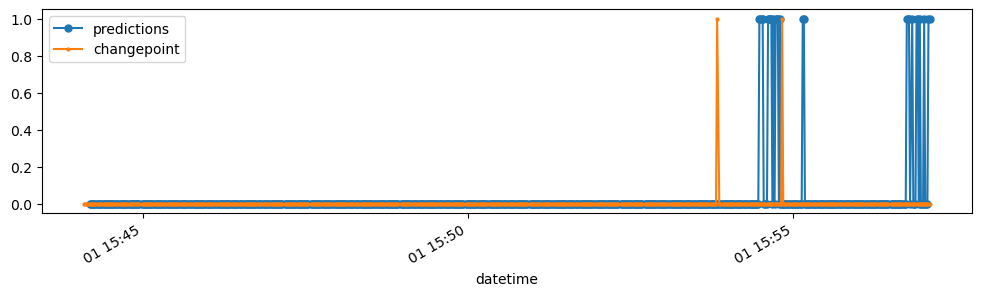

In [14]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Evaluation (metrics calculation)

In [20]:
# 'pip install tsad' if needed
from tsad.evaluating.evaluating import evaluating

### Binary classification (outlier detection) metrics

In [21]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 12.42 %
Missing Alarm Rate 29.08 %
F1 metric 0.74


### Changepoint detection metrics

In [22]:
# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Since you not choose numenta_time and portion, then portion will be 0.1
Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:21.620000'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:31.660000'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:14.100000'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:49.680000'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:50.680000'))
Amount of true anomalies 129
A number of missed CPs = 90
A number of FPs = 801
Average time 0 days 00:00:16.128205128


In [23]:
# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

Since you not choose numenta_time and portion, then portion will be 0.1
Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:21.620000'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:31.660000'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:14.100000'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:49.680000'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:50.680000'))
Standart  -  -8.83
LowFP  -  -43.47
LowFN  -  4.19
